In [56]:
import numpy as np
from sklearn.datasets import make_blobs
import time
from multiprocessing import Pool
import matplotlib.pyplot as plt

# Non-Parallel implementation

In [57]:
def generate_data(n_samples=70000, n_features=5, n_clusters=5, random_state=42):
    data, labels = make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=n_clusters,
        random_state=random_state
    )
    return data

In [58]:
def initialize_centroids(data, k):
    np.random.seed(42)
    indices = np.random.choice(data.shape[0], k, replace=False)
    return data[indices]

In [59]:
def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

In [60]:
def update_centroids(data, labels, k):
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

In [61]:
def has_converged(old_centroids, new_centroids, tol=1e-4):
    return np.all(np.linalg.norm(new_centroids - old_centroids, axis=1) < tol)

In [62]:
def kmeans(data, k, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(data, k)
    for _ in range(max_iters):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        if has_converged(centroids, new_centroids, tol):
            break
        centroids = new_centroids
    return centroids, labels

In [63]:
data = generate_data()

In [64]:
num_clusters = 5

In [65]:
start_time = time.time()
centroids, labels = kmeans(data, num_clusters)
end_time = time.time()

In [66]:
print(f"Non-parallel k-means completed in {end_time - start_time:.2f} seconds.")
non_parallel = end_time - start_time

Non-parallel k-means completed in 3.39 seconds.


# Parallel implementation

In [67]:
def generate_data(n_samples=70000, n_features=5, n_clusters=5, random_state=42):
    data, labels = make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=n_clusters,
        random_state=random_state
    )
    return data

In [68]:
def initialize_centroids(data, k):
    np.random.seed(42)
    indices = np.random.choice(data.shape[0], k, replace=False)
    return data[indices]

In [69]:
def parallel_distance_calc(chunk, centroids):
    distances = np.linalg.norm(chunk[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

In [70]:
def assign_clusters_parallel(data, centroids, n_workers=4):
    chunk_size = len(data) // n_workers
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]
    with Pool(n_workers) as pool:
        results = pool.starmap(parallel_distance_calc, [(chunk, centroids) for chunk in chunks])
    return np.concatenate(results)

In [71]:
def compute_partial_sum(chunk, labels_chunk, k, n_features):
    partial_sums = np.zeros((k, n_features))
    counts = np.zeros(k)
    for i in range(k):
        cluster_points = chunk[labels_chunk == i]
        partial_sums[i] = cluster_points.sum(axis=0)
        counts[i] = len(cluster_points)
    return partial_sums, counts

In [72]:
def parallel_centroid_update(data, labels, k, n_workers=4):
    n_features = data.shape[1]
    chunk_size = len(data) // n_workers
    chunks = [(data[i:i + chunk_size], labels[i:i + chunk_size]) for i in range(0, len(data), chunk_size)]
    with Pool(n_workers) as pool:
        results = pool.starmap(compute_partial_sum, [(chunk, lbls, k, n_features) for chunk, lbls in chunks])
    total_sums = np.sum([res[0] for res in results], axis=0)
    total_counts = np.sum([res[1] for res in results], axis=0)
    return total_sums / total_counts

In [73]:
def has_converged(old_centroids, new_centroids, tol=1e-4):
    return np.all(np.linalg.norm(new_centroids - old_centroids, axis=1) < tol)

In [74]:
def kmeans_parallel(data, k, max_iters=100, tol=1e-4, n_workers=4):
    centroids = initialize_centroids(data, k)
    for _ in range(max_iters):
        labels = assign_clusters_parallel(data, centroids, n_workers)
        new_centroids = parallel_centroid_update(data, labels, k, n_workers)
        if has_converged(centroids, new_centroids, tol):
            break
        centroids = new_centroids
    return centroids, labels

In [75]:
data = generate_data()

In [76]:
num_clusters = 5
n_workers_list = [1, 2, 4, 8]
linear_runtime = end_time - start_time

In [77]:
parallel_runtimes = []
speedups = []

In [78]:
for n_workers in n_workers_list:
    start_time = time.time()
    centroids, labels = kmeans_parallel(data, num_clusters, n_workers=n_workers)
    end_time = time.time()
    runtime = end_time - start_time
    parallel_runtimes.append(runtime)
    speedups.append(linear_runtime / runtime)

<ipython-input-72-241f5281ac75>:9: RuntimeWarning: divide by zero encountered in divide
  return total_sums / total_counts
<ipython-input-72-241f5281ac75>:9: RuntimeWarning: invalid value encountered in divide
  return total_sums / total_counts


In [79]:
parallel_runtimes, speedups

([15.627934217453003,
  15.890686988830566,
  25.99496626853943,
  43.63336515426636],
 [0.21721827231937507,
  0.21362656460492074,
  0.13058962398979568,
  0.07779993265781986])

# Results

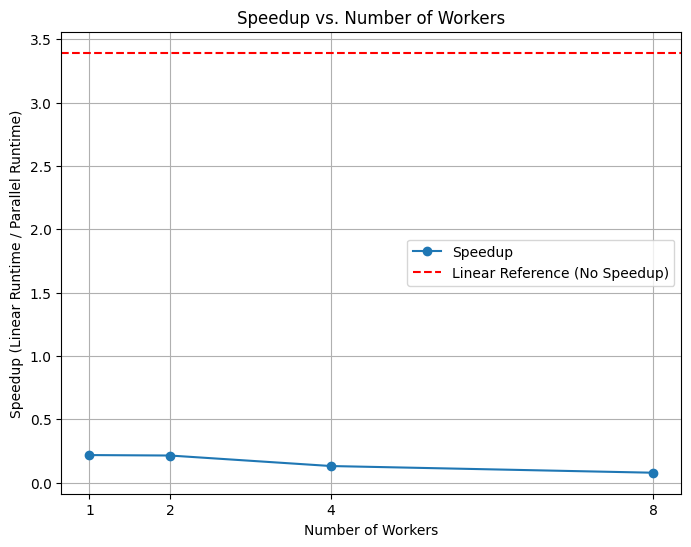

In [80]:
plt.figure(figsize=(8, 6))
plt.plot(n_workers_list, speedups, marker='o', label='Speedup')
plt.axhline(y=non_parallel, color='red', linestyle='--', label='Linear Reference (No Speedup)')
plt.title('Speedup vs. Number of Workers')
plt.xlabel('Number of Workers')
plt.ylabel('Speedup (Linear Runtime / Parallel Runtime)')
plt.xticks(n_workers_list)
plt.grid()
plt.legend()
plt.show()